In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import io
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# ───────────── Settings ─────────────
BUCKET       = 'bdc-public-curated'
PREFIX       = 'ndacan/nytd/outcomes/waves_processed/'

In [21]:
# ID and metadata columns
ID_COLS   = ['StFIPS','St', 'RepDate',]
DEM_COLS  = ['Sex','Race'] 
# Potential Predictors (Wave 1 only)
PREDICTORS = [
    'EmplySklls','SocSecrty','EducAid','PubFinAs','PubFoodAs','PubHousAs',
    'OthrFinAs','CnctAdult','Children','Marriage','Medicaid','OthrHlthIn',
    'MedicalIn','MentlHlthIn','PrescripIn'
]

# Potential Independents (OR‐combined across Wave 2 & 3)
INDEPENDENTS = [
    'HighEdCert','CurrenRoll','CurrFTE','CurrPTE','Homeless','SubAbuse','Incarc'
]
# Outcome to model in example
OUTCOME = 'Homeless'

In [22]:
# ───────────── Initialize S3 client & list files ─────────────
s3 = boto3.client('s3')

# Helpers

In [23]:
def s3_read_csv(key):
    """Load a CSV from S3 into a pandas DataFrame."""
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj['Body'].read()), dtype=str)

In [24]:
def normalize_keys(df, wave_tag):
    # 1) rename StFIPS_wX → StFIPS, etc.
    for col in ID_COLS:
        suff = f"{col}_{wave_tag}"
        if suff in df.columns:
            df.rename(columns={suff: col}, inplace=True)
    # 2) trim whitespace & unify types
    df[ID_COLS] = df[ID_COLS].astype(str).apply(lambda s: s.str.strip())
    # 3) parse dates
    df['RepDate'] = pd.to_datetime(df['RepDate'], errors='coerce')
    return df

In [1]:
# ───────────── 1) LOAD & NORMALIZE WAVES ─────────────
wave1 = s3_read_csv(f"{PREFIX}wave1.csv")
wave2 = s3_read_csv(f"{PREFIX}wave2.csv")
wave3 = s3_read_csv(f"{PREFIX}wave3.csv")
all_waves = s3_read_csv(f"{PREFIX}cleaned_all_waves.csv")
wave1 = normalize_keys(wave1, "w1")
wave2 = normalize_keys(wave2, "w2")
wave3 = normalize_keys(wave3, "w3")

print("Wave shapes:", wave1.shape, wave2.shape, wave3.shape)


NameError: name 's3_read_csv' is not defined

In [26]:
# ───────────── 2) BUILD combined wave2+3 FLAGS ─────────────
def drop_suffix_all(df, tag):
    return df.rename(columns=lambda c: re.sub(f'_{tag}$','',c,flags=re.IGNORECASE))

w2n = drop_suffix_all(wave2,'w2').assign(Wave=2)
w3n = drop_suffix_all(wave3,'w3').assign(Wave=3)

w23 = pd.concat([w2n,w3n],ignore_index=True).query("Wave in [2,3]")


In [27]:
# collapse raw codes to strict 0/1
for base in INDEPENDENTS:
    if base in w23.columns:
        w23[base] = (
            pd.to_numeric(w23[base],errors='coerce')
              .fillna(0)
              .apply(lambda x: 1 if x==1 else 0)
              .astype(int)
        )
    else:
        w23[base] = 0

combined = (
    w23.groupby(ID_COLS)[INDEPENDENTS]
       .max()    # OR across waves
       .reset_index()
)
print("Combined flags:", combined[INDEPENDENTS].sum())


Combined flags: HighEdCert    16
CurrenRoll    16
CurrFTE       16
CurrPTE       15
Homeless      16
SubAbuse      16
Incarc        16
dtype: int64


In [28]:
# ───────────── 3) MERGE BACK INTO WAVE1 ─────────────
df = pd.merge(wave1, combined, on=ID_COLS, how='left')
# rename any _y collisions back to base names
df = df.rename(columns={f"{b}_y":b for b in INDEPENDENTS})
df[INDEPENDENTS] = df[INDEPENDENTS].fillna(0).astype(int)

print("Final df.shape:", df.shape)

Final df.shape: (3068, 45)


In [29]:
# ───────────── 4) CLEAN special codes 77/88/99 ─────────────
to_clean = df.filter(regex=r'(_w[123]$)|^(Baseline|Responded|Elig19|Elig21)$').columns
df[to_clean] = (
    df[to_clean]
      .apply(pd.to_numeric,errors='coerce')
      .replace({77:np.nan,88:np.nan,99:np.nan})
      .fillna(0)
      .astype(int)
)

In [ ]:
records = []

for pred in PREDICTORS:
    # now your Wave-1 predictor is literally named “EmplySklls”, etc.
    if pred not in df.columns:
        continue

    for indep in INDEPENDENTS:
        if indep not in df.columns:
            continue

        # build the raw count table
        ct = pd.crosstab(df[pred], df[indep])
        if ct.empty:
            continue

        # build the row‐percent table
        pct = ct.div(ct.sum(axis=1), axis=0) * 100

        # melt both into long form
        df_ct  = ct.reset_index().melt(id_vars=pred,
                                       var_name=indep,
                                       value_name="count")
        df_pct = pct.reset_index().melt(id_vars=pred,
                                        var_name=indep,
                                        value_name="pct")

        # merge and annotate
        m = df_ct.merge(df_pct, on=[pred, indep])
        m["predictor"]   = pred
        m["independent"] = indep

        records.append(m)

if records:
    result_df = pd.concat(records, ignore_index=True)


In [31]:
# Simply save your DataFrame to a CSV in the current working directory:
result_df.to_csv('results_df.csv', index=False)
print("Saved result_df to 'results_df.csv'")


Saved result_df to 'results_df.csv'


In [32]:
# ───────────── 6) OPTIONAL: MODELING ─────────────
real_preds = [c for c in df if re.match(r'('+'|'.join(PREDICTORS)+r')_w1$',c)]
if df[OUTCOME].nunique()>1 and len(df)>10:
    X_train,X_test,y_train,y_test = train_test_split(
        df[real_preds], df[OUTCOME], stratify=df[OUTCOME], random_state=42
    )
    scaler = StandardScaler().fit(X_train)
    m = LogisticRegression(max_iter=1000).fit(scaler.transform(X_train),y_train)
    y_pred = m.predict(scaler.transform(X_test))
    print("\nClassification Report:\n",
          classification_report(y_test,y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

# stats

In [33]:
# 1) Load the CSV (use read_csv, not read_excel, since it’s a .csv)
df = pd.read_csv(
    r"C:\Users\emros\OneDrive\Desktop\NYPD\cleaned_reports\results_df.csv"
)

In [34]:
# 2) Quick overview
print("DataFrame shape:", df.shape)
print("\nColumn dtypes:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

DataFrame shape: (504, 26)

Column dtypes:
 EmplySklls     float64
HighEdCert     float64
count            int64
pct            float64
predictor       object
independent     object
CurrenRoll     float64
CurrFTE        float64
CurrPTE        float64
Homeless       float64
SubAbuse       float64
Incarc         float64
SocSecrty      float64
EducAid        float64
PubFinAs       float64
PubFoodAs      float64
PubHousAs      float64
OthrFinAs      float64
CnctAdult      float64
Children       float64
Marriage       float64
Medicaid       float64
OthrHlthIn     float64
MedicalIn      float64
MentlHlthIn    float64
PrescripIn     float64
dtype: object

First 5 rows:
    EmplySklls  HighEdCert  count    pct   predictor independent  CurrenRoll  \
0         0.0         0.0   1388  100.0  EmplySklls  HighEdCert         NaN   
1         1.0         0.0    259  100.0  EmplySklls  HighEdCert         NaN   
2         2.0         0.0     35  100.0  EmplySklls  HighEdCert         NaN   
3        77.

In [36]:
# 3) Descriptive statistics for numeric columns
numberic = print("\nNumeric summary (describe):\n", df.describe())

# 4) Unique values per column (for categorical inspection)
for col in df.columns:
    uniques = df[col].nunique(dropna=False)
    print(f"{col!r} unique values: {uniques}")
    


Numeric summary (describe):
        EmplySklls  HighEdCert        count    pct  CurrenRoll  CurrFTE  \
count   28.000000        72.0   504.000000  504.0        72.0     72.0   
mean    20.000000         0.0   639.166667  100.0         0.0      0.0   
std     33.520585         0.0   672.276885    0.0         0.0      0.0   
min      0.000000         0.0     1.000000  100.0         0.0      0.0   
25%      0.750000         0.0    24.750000  100.0         0.0      0.0   
50%      1.500000         0.0   147.500000  100.0         0.0      0.0   
75%     20.750000         0.0  1386.000000  100.0         0.0      0.0   
max     77.000000         0.0  1612.000000  100.0         0.0      0.0   

       CurrPTE  Homeless  SubAbuse  Incarc  ...  PubHousAs  OthrFinAs  \
count     72.0      72.0      72.0    72.0  ...  35.000000  28.000000   
mean       0.0       0.0       0.0     0.0  ...  33.600000  20.000000   
std        0.0       0.0       0.0     0.0  ...  40.668097  33.520585   
min        

In [40]:
# 1) Numeric summary
numeric_summary = df.describe().T
print("\n### Numeric Summary (describe)\n")
print(numeric_summary.to_markdown())

# 2) Unique values per column
unique_counts = {col: df[col].nunique(dropna=False) for col in df.columns}
unique_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['unique_count'])
print("\n### Unique Values per Column\n")
print(unique_df.to_markdown())


### Numeric Summary (describe)

|             |   count |    mean |      std |   min |    25% |   50% |     75% |   max |
|:------------|--------:|--------:|---------:|------:|-------:|------:|--------:|------:|
| EmplySklls  |      28 |  20     |  33.5206 |     0 |   0.75 |   1.5 |   20.75 |    77 |
| HighEdCert  |      72 |   0     |   0      |     0 |   0    |   0   |    0    |     0 |
| count       |     504 | 639.167 | 672.277  |     1 |  24.75 | 147.5 | 1386    |  1612 |
| pct         |     504 | 100     |   0      |   100 | 100    | 100   |  100    |   100 |
| CurrenRoll  |      72 |   0     |   0      |     0 |   0    |   0   |    0    |     0 |
| CurrFTE     |      72 |   0     |   0      |     0 |   0    |   0   |    0    |     0 |
| CurrPTE     |      72 |   0     |   0      |     0 |   0    |   0   |    0    |     0 |
| Homeless    |      72 |   0     |   0      |     0 |   0    |   0   |    0    |     0 |
| SubAbuse    |      72 |   0     |   0      |     0 |   0    |   0

In [39]:
# 5) For each predictor–independent pair, show overall counts and percentages
grouped = (
    df
      .groupby(['predictor','independent'])[ ['count','pct'] ]
      .agg(['sum','mean','median','min','max'])
)
print("\nAggregated stats by predictor & independent:\n", grouped)


Aggregated stats by predictor & independent:
                       count                             pct                \
                        sum   mean median  min   max    sum   mean median   
predictor independent                                                       
Children  CurrFTE      3068  767.0  759.5  102  1447  400.0  100.0  100.0   
          CurrPTE      3068  767.0  759.5  102  1447  400.0  100.0  100.0   
          CurrenRoll   3068  767.0  759.5  102  1447  400.0  100.0  100.0   
          HighEdCert   3068  767.0  759.5  102  1447  400.0  100.0  100.0   
          Homeless     3068  767.0  759.5  102  1447  400.0  100.0  100.0   
...                     ...    ...    ...  ...   ...    ...    ...    ...   
SocSecrty CurrenRoll   3068  767.0  774.0   34  1486  400.0  100.0  100.0   
          HighEdCert   3068  767.0  774.0   34  1486  400.0  100.0  100.0   
          Homeless     3068  767.0  774.0   34  1486  400.0  100.0  100.0   
          Incarc       3068  

In [44]:
# 1) Numeric summary
numeric_summary = df.describe().T

# 2) Save to CSV (includes the index as the first column)
numeric_summary.to_csv("numeric_summary.csv", index=True)

print("Saved numeric summary to numeric_summary.csv")


Saved numeric summary to numeric_summary.csv


In [ ]:
# 7) Save summaries to CSV
df.describe().to_csv('numeric_describe.csv')
grouped.to_csv('grouped_stats.csv')

print("\n✅ Wrote:\n - numeric_describe.csv\n - grouped_stats.csv\n")


✅ Wrote:
 - numeric_describe.csv
 - grouped_stats.csv
 - pivot_mean_pct.csv


# Simple

### Homeless by wave

In [49]:
wave1.head()

,Wave,StFCID,StFIPS,St,RepDate,Sex,OutcmRpt,OutcmDte,OutcmFCS,CurrFTE,...,MedicalIn,MentlHlthIn,PrescripIn,Baseline,FY11Cohort,Elig19,Elig21,Responded,Cohort,Race
0,1,NaN,47.0,TN,2011-09-01,2.0,1.0,2011-10-06,1.0,0.0,...,88.0,88.0,88.0,1.0,1.0,1.0,1.0,1,FY11,1.0
1,1,NaN,47.0,TN,2011-09-01,1.0,1.0,2011-11-09,1.0,0.0,...,88.0,88.0,88.0,1.0,0.0,0.0,1.0,1,FY11,2.0
2,1,NaN,47.0,TN,2011-09-01,1.0,77.0,2015-09-30,0.0,77.0,...,77.0,77.0,77.0,1.0,0.0,0.0,1.0,0,FY11,2.0
3,1,NaN,47.0,TN,2011-09-01,2.0,1.0,2011-08-24,1.0,0.0,...,88.0,88.0,88.0,1.0,1.0,1.0,1.0,1,FY11,99.0
4,1,NaN,47.0,TN,2011-09-01,1.0,7.0,2011-08-31,1.0,77.0,...,77.0,77.0,77.0,1.0,0.0,0.0,1.0,0,FY11,2.0


### wave Homelesss

In [60]:
import pandas as pd

# Assume wave1, wave2, wave3 are already loaded DataFrames

for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    # 1) Find the Homeless column (with or without _w suffix)
    homeless_col = next(
        c for c in df_w.columns 
        if c.lower().startswith('homeless')
    )
    
    # 2) Coerce to numeric
    flags = pd.to_numeric(df_w[homeless_col], errors='coerce')
    
    # 3) Binarize: 1 stays 1; everything else → 0
    binary = flags.apply(lambda x: 1 if x == 1 else 0)
    
    # 4) Compute percentages
    pct = binary.value_counts(normalize=True) * 100
    
    # 5) Print results
    print(f"{label} ({homeless_col}):")
    print(f"  Homeless = 1    : {pct.get(1, 0):.1f}%")
    print(f"  Homeless ≠ 1  : {pct.get(0, 0):.1f}%\n")


Wave 1 (Homeless):
  Homeless = 1    : 5.2%
  Homeless ≠ 1  : 94.8%

Wave 2 (Homeless):
  Homeless = 1    : 7.7%
  Homeless ≠ 1  : 92.3%

Wave 3 (Homeless):
  Homeless = 1    : 15.8%
  Homeless ≠ 1  : 84.2%



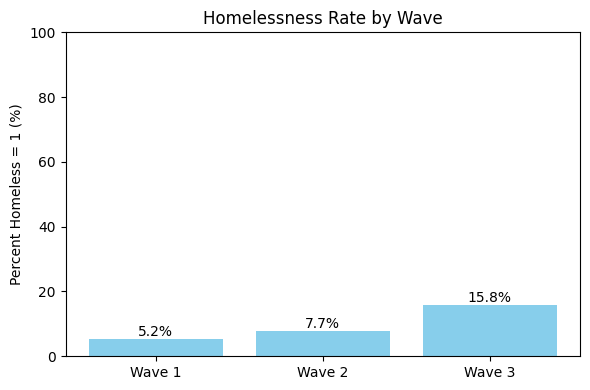

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute percent Homeless=1 for each wave
results = []
for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    # find the Homeless column (with or without suffix)
    homeless_col = next(c for c in df_w.columns if c.lower().startswith('homeless'))
    
    # coerce to numeric and binarize: 1 stays 1, everything else → 0
    flags = pd.to_numeric(df_w[homeless_col], errors='coerce').fillna(0).astype(int)
    binary = flags.apply(lambda x: 1 if x == 1 else 0)
    
    # compute percent of 1’s
    pct = binary.mean() * 100
    results.append({'Wave': label, 'Percent Homeless': pct})

# 2) Build a summary DataFrame
summary = pd.DataFrame(results)

# 3) Plot a simple bar chart
plt.figure(figsize=(6,4))
plt.bar(summary['Wave'], summary['Percent Homeless'], color='skyblue')
plt.ylim(0, 100)
for i, pct in enumerate(summary['Percent Homeless']):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.ylabel('Percent Homeless = 1 (%)')
plt.title('Homelessness Rate by Wave')
plt.tight_layout()
plt.show()


   Wave  Percent Homeless
 Wave 1          5.182529
 Wave 2          7.709251
 Wave 3         15.789474
Overall          7.695167


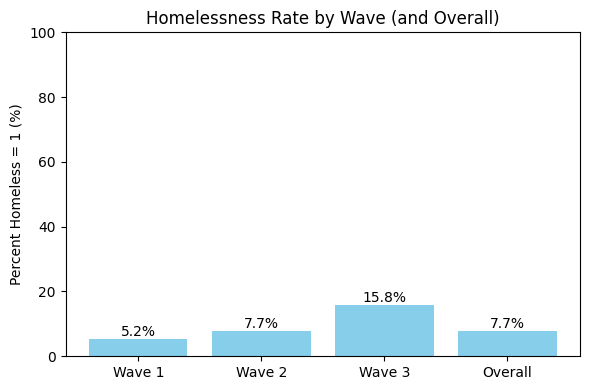

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume wave1, wave2, wave3 are already loaded DataFrames

# 1) Helper to extract & clean the homeless flag from a wave
def get_homeless_flag(df):
    col = next(c for c in df.columns if c.lower().startswith('homeless'))
    return (
        pd.to_numeric(df[col], errors='coerce')
          .fillna(0)
          .astype(int)
          .apply(lambda x: 1 if x == 1 else 0)
    )

# 2) Compute per‐wave percentages
results = []
for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    flag = get_homeless_flag(df_w)
    pct = flag.mean() * 100
    results.append({'Wave': label, 'Percent Homeless': pct})

# 3) Compute overall across all waves
all_flags = pd.concat([get_homeless_flag(wave1),
                       get_homeless_flag(wave2),
                       get_homeless_flag(wave3)], ignore_index=True)
overall_pct = all_flags.mean() * 100
results.append({'Wave': 'Overall', 'Percent Homeless': overall_pct})

# 4) Build a DataFrame
summary = pd.DataFrame(results)

# 5) Print the table
print(summary.to_string(index=False))

# 6) Plot
plt.figure(figsize=(6,4))
plt.bar(summary['Wave'], summary['Percent Homeless'], color='skyblue')
plt.ylim(0, 100)
for i, pct in enumerate(summary['Percent Homeless']):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.ylabel('Percent Homeless = 1 (%)')
plt.title('Homelessness Rate by Wave (and Overall)')
plt.tight_layout()
plt.show()


SubAbuse

   Wave  Percent SubAbuse = 1
 Wave 1             21.936115
 Wave 2              6.461087
 Wave 3              6.526316
Overall             15.297398


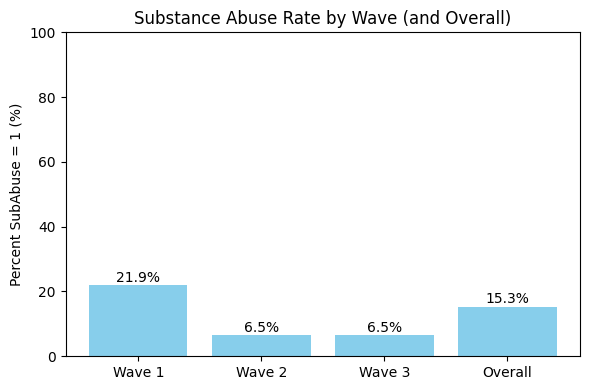

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume wave1, wave2, wave3 are already loaded DataFrames

# 1) Helper to extract & clean the SubAbuse flag from a wave
def get_abuse_flag(df):
    col = next(c for c in df.columns if c.lower().startswith('subabuse'))
    return (
        pd.to_numeric(df[col], errors='coerce')
          .fillna(0)
          .astype(int)
          .apply(lambda x: 1 if x == 1 else 0)
    )

# 2) Compute per-wave percentages
results = []
for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    flag = get_abuse_flag(df_w)
    pct = flag.mean() * 100
    results.append({'Wave': label, 'Percent SubAbuse = 1': pct})

# 3) Compute overall across all waves
all_flags = pd.concat([
    get_abuse_flag(wave1),
    get_abuse_flag(wave2),
    get_abuse_flag(wave3)
], ignore_index=True)
overall_pct = all_flags.mean() * 100
results.append({'Wave': 'Overall', 'Percent SubAbuse = 1': overall_pct})

# 4) Build a DataFrame
summary = pd.DataFrame(results)

# 5) Print the table
print(summary.to_string(index=False))

# 6) Plot
plt.figure(figsize=(6,4))
plt.bar(summary['Wave'], summary['Percent SubAbuse = 1'], color='skyblue')
plt.ylim(0, 100)
for i, pct in enumerate(summary['Percent SubAbuse = 1']):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.ylabel('Percent SubAbuse = 1 (%)')
plt.title('Substance Abuse Rate by Wave (and Overall)')
plt.tight_layout()
plt.show()


Incarcerated

   Wave  Percent Incarc = 1
 Wave 1           25.456323
 Wave 2           10.939794
 Wave 3           17.894737
Overall           20.446097


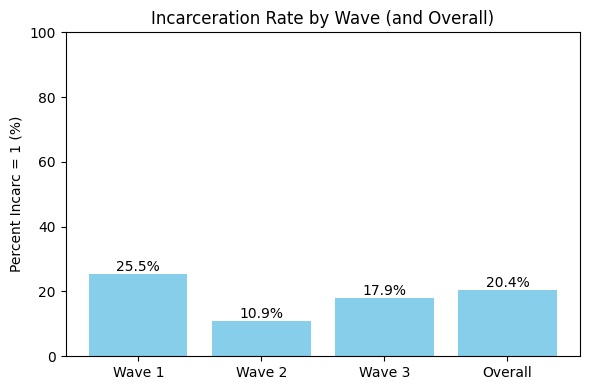

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume wave1, wave2, wave3 are already loaded DataFrames

# 1) Helper to extract & clean the Incarc flag from a wave
def get_incarc_flag(df):
    # finds columns like "Incarc" or "Incarc_w1"/"_w2"/"_w3"
    col = next(c for c in df.columns if c.lower().startswith('incarc'))
    return (
        pd.to_numeric(df[col], errors='coerce')
          .fillna(0)
          .astype(int)
          .apply(lambda x: 1 if x == 1 else 0)
    )

# 2) Compute per-wave percentages
results = []
for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    flag = get_incarc_flag(df_w)
    pct = flag.mean() * 100
    results.append({'Wave': label, 'Percent Incarc = 1': pct})

# 3) Compute overall across all waves
all_flags = pd.concat([
    get_incarc_flag(wave1),
    get_incarc_flag(wave2),
    get_incarc_flag(wave3)
], ignore_index=True)
overall_pct = all_flags.mean() * 100
results.append({'Wave': 'Overall', 'Percent Incarc = 1': overall_pct})

# 4) Build a DataFrame
summary = pd.DataFrame(results)

# 5) Print the table
print(summary.to_string(index=False))

# 6) Plot
plt.figure(figsize=(6,4))
plt.bar(summary['Wave'], summary['Percent Incarc = 1'], color='skyblue')
plt.ylim(0, 100)
for i, pct in enumerate(summary['Percent Incarc = 1']):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.ylabel('Percent Incarc = 1 (%)')
plt.title('Incarceration Rate by Wave (and Overall)')
plt.tight_layout()
plt.show()


Has children

   Wave  Percent Has Children = 1
 Wave 1                  3.324641
 Wave 2                  5.359765
 Wave 3                 16.526316
Overall                  6.171004


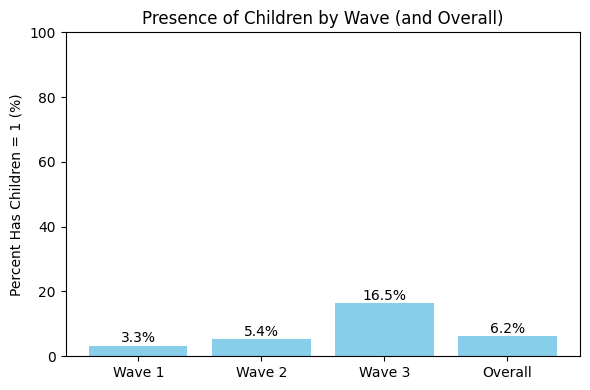

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume wave1, wave2, wave3 are already loaded DataFrames

# 1) Helper to extract & clean the Children flag from a wave
def get_children_flag(df):
    # finds columns like "Children" or "Children_w1"/"_w2"/"_w3"
    col = next(c for c in df.columns if c.lower().startswith('children'))
    return (
        pd.to_numeric(df[col], errors='coerce')
          .fillna(0)
          .astype(int)
          .apply(lambda x: 1 if x == 1 else 0)
    )

# 2) Compute per-wave percentages
results = []
for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
    flag = get_children_flag(df_w)
    pct = flag.mean() * 100
    results.append({'Wave': label, 'Percent Has Children = 1': pct})

# 3) Compute overall across all waves
all_flags = pd.concat([
    get_children_flag(wave1),
    get_children_flag(wave2),
    get_children_flag(wave3)
], ignore_index=True)
overall_pct = all_flags.mean() * 100
results.append({'Wave': 'Overall', 'Percent Has Children = 1': overall_pct})

# 4) Build a DataFrame
summary = pd.DataFrame(results)

# 5) Print the table
print(summary.to_string(index=False))

# 6) Plot
plt.figure(figsize=(6,4))
plt.bar(summary['Wave'], summary['Percent Has Children = 1'], color='skyblue')
plt.ylim(0, 100)
for i, pct in enumerate(summary['Percent Has Children = 1']):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
plt.ylabel('Percent Has Children = 1 (%)')
plt.title('Presence of Children by Wave (and Overall)')
plt.tight_layout()
plt.show()


Marriage

   Wave  Percent Marriage=1
 Wave 1            0.032595
 Wave 2            0.954479
 Wave 3            2.000000
Overall            0.613383


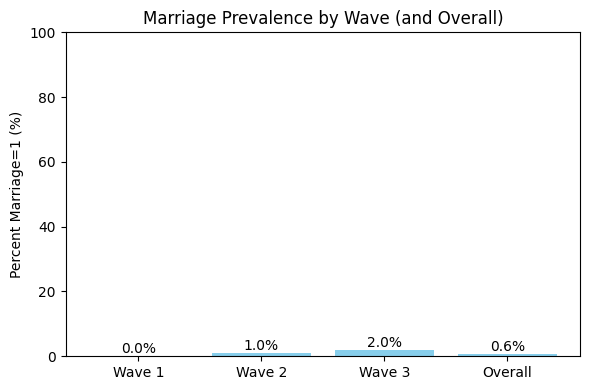

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume wave1, wave2, wave3 are already loaded DataFrames

def plot_flag_across_waves(prefix):
    """
    For a given flag prefix (e.g. "Marriage"), computes and plots
    the percent =1 in each wave and overall.
    """
    # 1) Helper to extract & clean the flag
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    # 2) Compute per‐wave percentages
    results = []
    for label, df_w in [('Wave 1', wave1), ('Wave 2', wave2), ('Wave 3', wave3)]:
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # 3) Compute overall
    all_flags = pd.concat([ get_flag(wave1),
                             get_flag(wave2),
                             get_flag(wave3) ],
                           ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    # 4) Build and display summary
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    # 5) Plot
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Prevalence by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Run it for Marriage
plot_flag_across_waves('Marriage')


Trusted adult

   Wave  Percent CnctAdult=1
 Wave 1            52.542373
 Wave 2            34.067548
 Wave 3            53.684211
Overall            48.066914


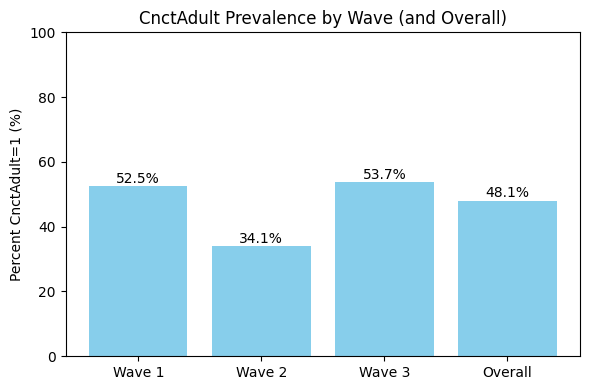

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given flag prefix (e.g. "CnctAdult"), computes and plots
    the percent =1 in each wave and overall.
    """
    # Helper to extract & clean the flag column
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    # Compute per‐wave percentages
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # Compute overall
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    # Build summary DataFrame
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Prevalence by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your waves dict
waves = {'Wave 1': wave1, 'Wave 2': wave2, 'Wave 3': wave3}

# And call it for CnctAdult
plot_flag_across_waves('CnctAdult', waves)


High school degree

   Wave  Percent HighEdCert=1
 Wave 1              2.151239
 Wave 2             21.512482
 Wave 3             33.052632
Overall             12.509294


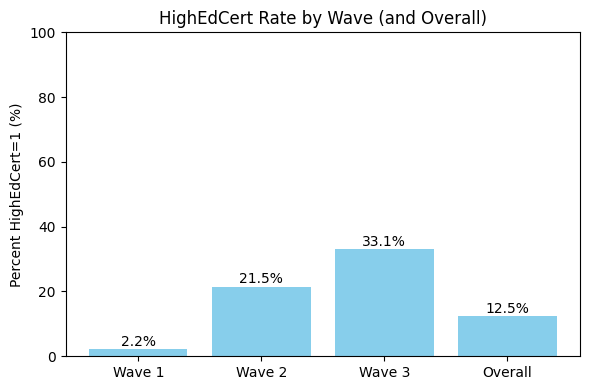

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Re-use the helper function from before (or redefine it here)
def plot_flag_across_waves(prefix, waves):
    """
    For a given flag prefix (e.g. "HighEdCert"), computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Run it for HighEdCert
plot_flag_across_waves('HighEdCert', waves)


Currently enrolled in school

   Wave  Percent CurrenRoll=1
 Wave 1             51.466754
 Wave 2             14.757709
 Wave 3             17.789474
Overall             36.226766


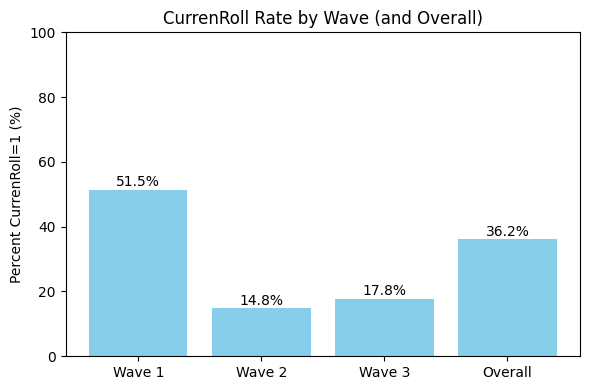

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given flag prefix (e.g. "CurrenRoll"), computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Plot for school enrollment (CurrenRoll)
plot_flag_across_waves('CurrenRoll', waves)


Full time employment

   Wave  Percent CurrFTE=1
 Wave 1           0.488918
 Wave 2           8.516887
 Wave 3          15.473684
Overall           5.167286


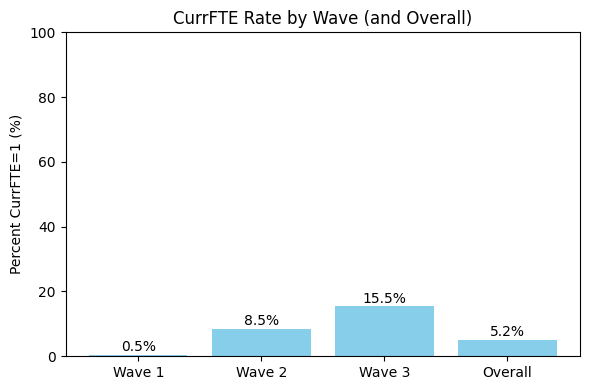

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# And now plot for CurrFTE
plot_flag_across_waves('CurrFTE', waves)


Partime employment

   Wave  Percent CurrPTE=1
 Wave 1           4.791395
 Wave 2           7.342144
 Wave 3           9.052632
Overall           6.189591


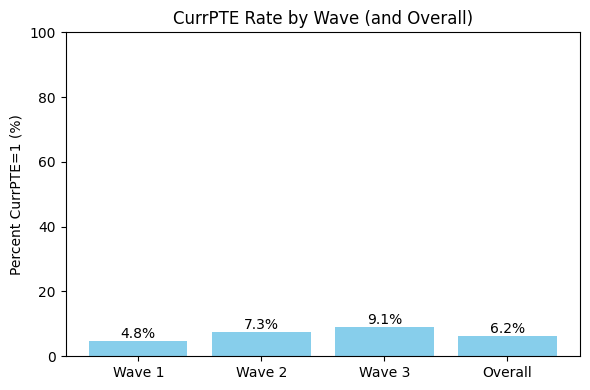

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# And now plot for CurrPTE (part-time employment)
plot_flag_across_waves('CurrPTE', waves)


Social Security Benifits

   Wave  Percent SocSecrty=1
 Wave 1             5.280313
 Wave 2             3.671072
 Wave 3             4.736842
Overall             4.776952


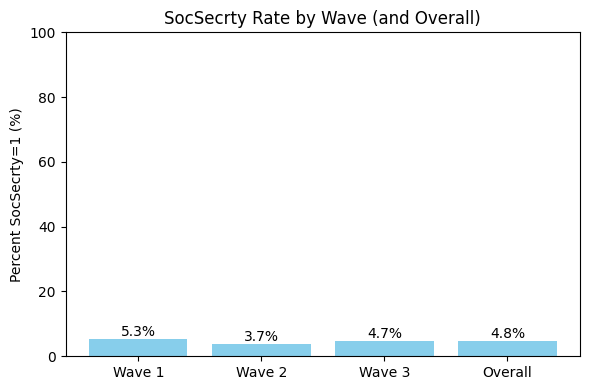

In [73]:
# Copy-and-paste this after you’ve loaded wave1, wave2, and wave3

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Plot for SocSecrty (Social Security access)
plot_flag_across_waves('SocSecrty', waves)


Educaton aid

   Wave  Percent EducAid=1
 Wave 1           1.271186
 Wave 2           6.754772
 Wave 3           4.631579
Overall           3.252788


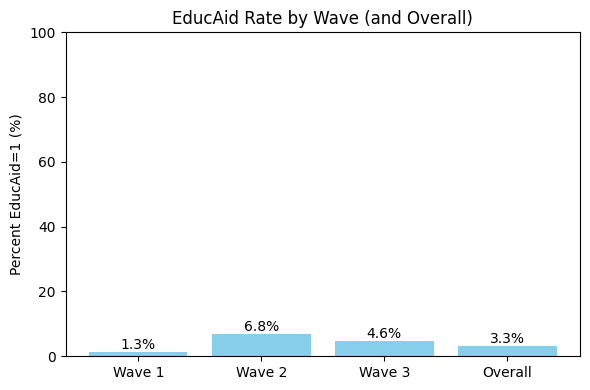

In [74]:
# Copy-and-paste this cell after you’ve loaded wave1, wave2, and wave3

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# And now plot for EducAid (Educational Aid access)
plot_flag_across_waves('EducAid', waves)


Public Financial aid

   Wave  Percent PubFinAs=1
 Wave 1            0.814863
 Wave 2            0.954479
 Wave 3            2.210526
Overall            1.096654


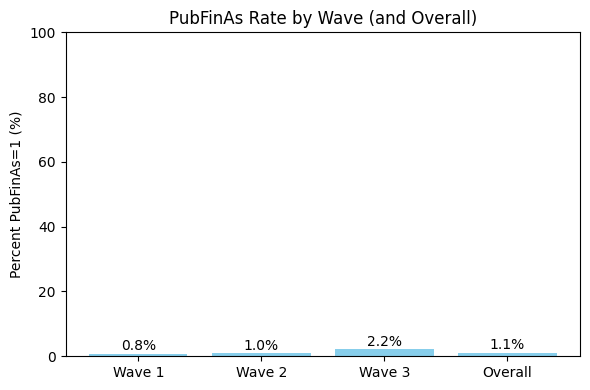

In [75]:
# Copy-and-paste this cell after you’ve loaded wave1, wave2, and wave3

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# And now plot for PubFinAs (Public Financial Assistance access)
plot_flag_across_waves('PubFinAs', waves)


Public food assistance

   Wave  Percent PubFoodAs=1
 Wave 1             0.945241
 Wave 2             8.223201
 Wave 3            15.157895
Overall             5.297398


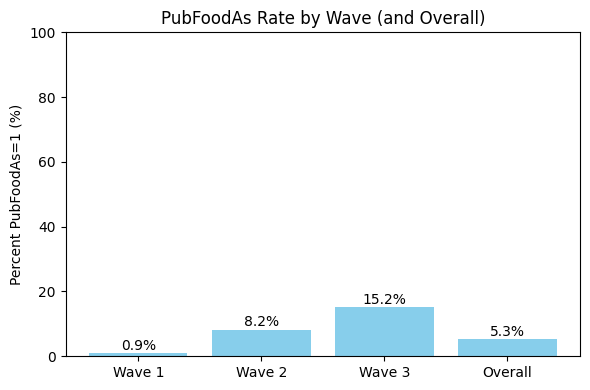

In [76]:
# After you’ve loaded wave1, wave2, and wave3 into memory:

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for PubFoodAs (Public Food Assistance access)
plot_flag_across_waves('PubFoodAs', waves)


Public housing assistance

   Wave  Percent PubHousAs=1
 Wave 1             0.423729
 Wave 2             1.248164
 Wave 3             2.947368
Overall             1.078067


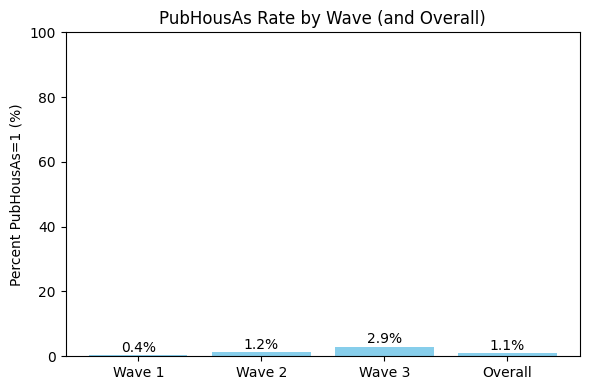

In [77]:
# After you’ve loaded wave1, wave2, and wave3 into memory:

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        # find the column that starts with the prefix (case‐insensitive)
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')  # convert strings to numbers
              .fillna(0)                             # non‐numeric → 0
              .astype(int)                           # make ints
              .apply(lambda x: 1 if x == 1 else 0)   # binarize: only 1 stays 1
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for PubHousAs (Public Housing Assistance access)
plot_flag_across_waves('PubHousAs', waves)


Other financial assistance

   Wave  Percent OthrFinAs=1
 Wave 1             2.086050
 Wave 2             2.716593
 Wave 3             2.842105
Overall             2.379182


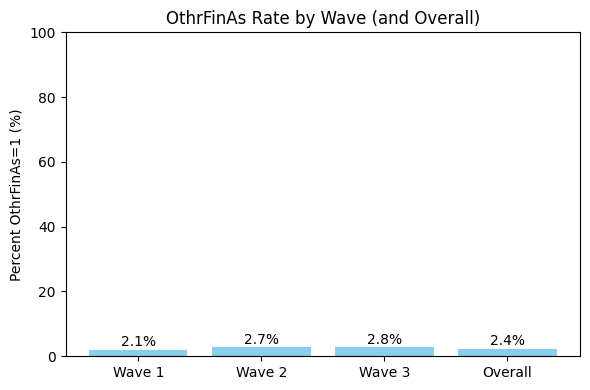

In [78]:
# After you’ve loaded wave1, wave2, and wave3 into memory:

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    def get_flag(df):
        # find the column that starts with the prefix (case‐insensitive)
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')  # convert strings to numbers
              .fillna(0)                             # non‐numeric → 0
              .astype(int)                           # make ints
              .apply(lambda x: 1 if x == 1 else 0)   # binarize: only 1 stays 1
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for OthrFinAs (Other Financial Assistance access)
plot_flag_across_waves('OthrFinAs', waves)


Has Medicaid

   Wave  Percent Medicaid=1
 Wave 1           51.564537
 Wave 2           29.588840
 Wave 3           42.947368
Overall           44.479554


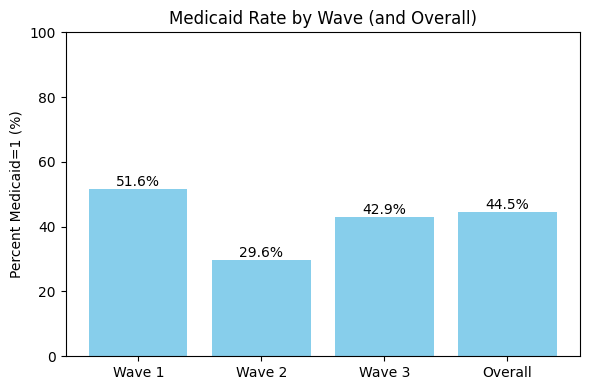

In [79]:
# After you’ve loaded wave1, wave2, and wave3 into memory:

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        # find the column that starts with the prefix (case‐insensitive)
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')  # convert to numeric
              .fillna(0)                             # non‐numeric → 0
              .astype(int)                           # ints
              .apply(lambda x: 1 if x == 1 else 0)   # binarize: only 1 stays 1
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for Medicaid
plot_flag_across_waves('Medicaid', waves)


Has other health insurance

   Wave  Percent OthrHlthIn=1
 Wave 1              3.292047
 Wave 2              3.671072
 Wave 3              6.526316
Overall              3.959108


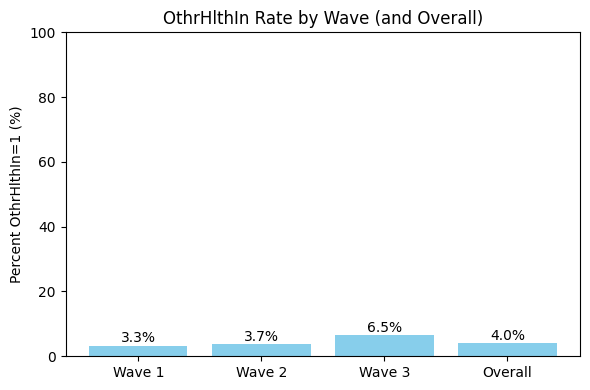

In [80]:
# After you’ve loaded wave1, wave2, and wave3 into memory:

import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        # find the column that starts with the prefix (case‐insensitive)
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')  # convert to numeric
              .fillna(0)                             # non‐numeric → 0
              .astype(int)                           # ints
              .apply(lambda x: 1 if x == 1 else 0)   # binarize: only 1 stays 1
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for OthrHlthIn (Other Health Insurance access)
plot_flag_across_waves('OthrHlthIn', waves)


Has medical Incerance

   Wave  Percent MedicalIn=1
 Wave 1             3.063885
 Wave 2             3.524229
 Wave 3             6.210526
Overall             3.736059


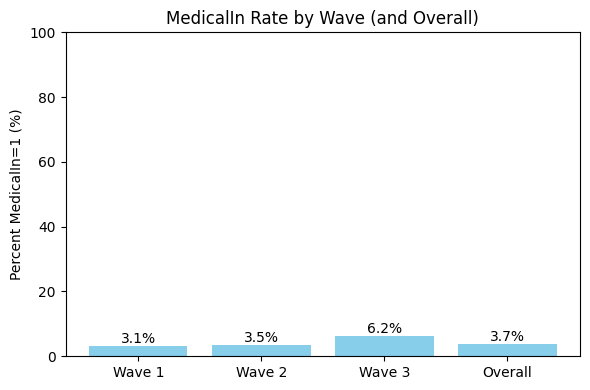

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now plot for MedicalIn
plot_flag_across_waves('MedicalIn', waves)


For mental Health insurance

   Wave  Percent MentlHlthIn=1
 Wave 1               2.737940
 Wave 2               2.863436
 Wave 3               4.631579
Overall               3.104089


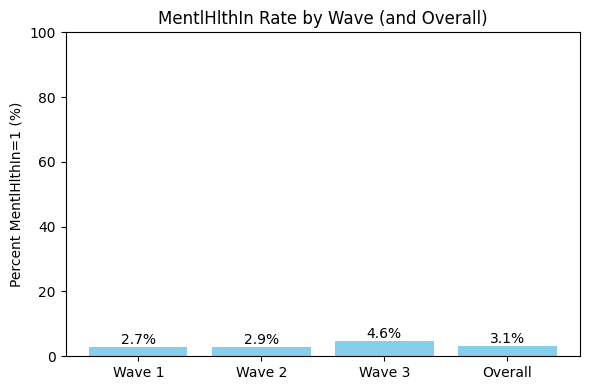

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Your wave DataFrames
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now call it:
plot_flag_across_waves('MentlHlthIn', waves)


Has perscription insurance

   Wave  Percent PrescripIn=1
 Wave 1              3.031291
 Wave 2              3.303965
 Wave 3              6.105263
Overall              3.643123


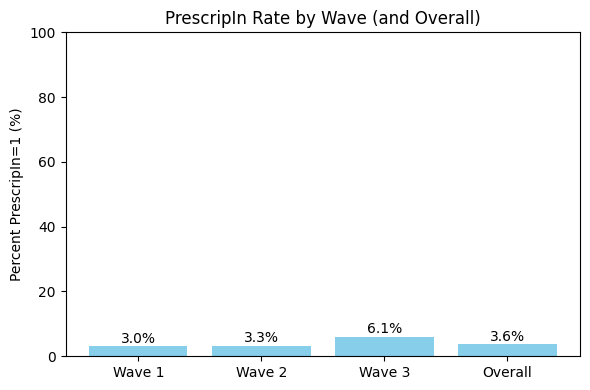

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now call it for PrescripIn
plot_flag_across_waves('PrescripIn', waves)


have education certificat

   Wave  Percent HighEdCert=1
 Wave 1              2.151239
 Wave 2             21.512482
 Wave 3             33.052632
Overall             12.509294


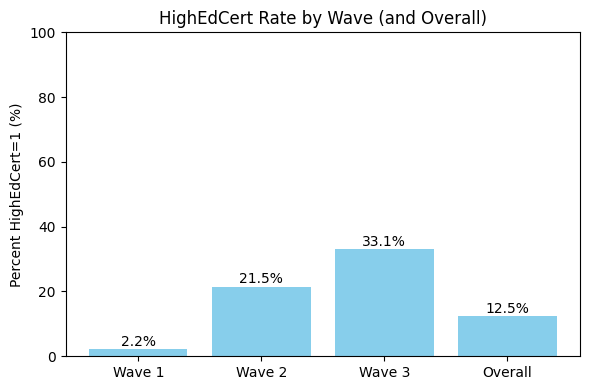

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix, computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )
    
    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})
    
    # overall across all waves
    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})
    
    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))
    
    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Now call it for HighEdCert
plot_flag_across_waves('HighEdCert', waves)


Are enrolled in education/training programs

   Wave  Percent CurrenRoll=1
 Wave 1             51.466754
 Wave 2             14.757709
 Wave 3             17.789474
Overall             36.226766


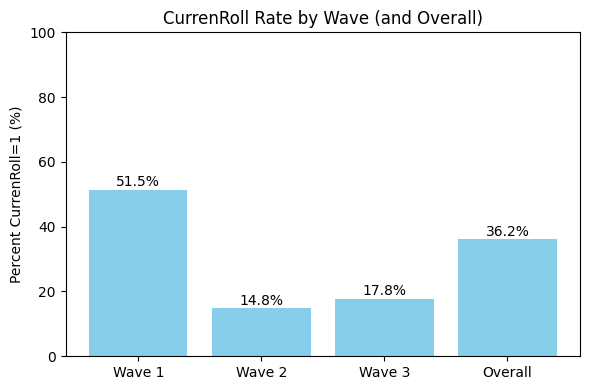

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_flag_across_waves(prefix, waves):
    """
    For a given binary flag prefix (e.g. "CurrenRoll"), computes and plots
    the percent =1 in each wave and overall.
    """
    def get_flag(df):
        col = next(c for c in df.columns if c.lower().startswith(prefix.lower()))
        return (
            pd.to_numeric(df[col], errors='coerce')
              .fillna(0)
              .astype(int)
              .apply(lambda x: 1 if x == 1 else 0)
        )

    results = []
    for label, df_w in waves.items():
        flag = get_flag(df_w)
        pct  = flag.mean() * 100
        results.append({'Wave': label, f'Percent {prefix}=1': pct})

    all_flags = pd.concat([get_flag(df) for df in waves.values()], ignore_index=True)
    overall_pct = all_flags.mean() * 100
    results.append({'Wave': 'Overall', f'Percent {prefix}=1': overall_pct})

    summary = pd.DataFrame(results)
    print(summary.to_string(index=False))

    plt.figure(figsize=(6,4))
    plt.bar(summary['Wave'], summary[f'Percent {prefix}=1'], color='skyblue')
    plt.ylim(0, 100)
    for i, pct in enumerate(summary[f'Percent {prefix}=1']):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylabel(f'Percent {prefix}=1 (%)')
    plt.title(f'{prefix} Rate by Wave (and Overall)')
    plt.tight_layout()
    plt.show()

# Define your wave DataFrames dictionary
waves = {
    'Wave 1': wave1,
    'Wave 2': wave2,
    'Wave 3': wave3,
}

# Finally, call it for CurrenRoll
plot_flag_across_waves('CurrenRoll', waves)


# Data based on people who answered all 3 waves

In [86]:
def filter_reported(df):
    # 1) find the OutcmRpt column
    col = next(c for c in df.columns if c.lower().startswith('outcmrpt'))
    # 2) coerce to numeric 0/1
    rpt = (
        pd.to_numeric(df[col], errors='coerce')
          .fillna(0)
          .astype(int)
    )
    # 3) filter where reported == 1
    return df[rpt == 1].copy()

# Apply to each wave
reported_wave1 = filter_reported(wave1)
reported_wave2 = filter_reported(wave2)
reported_wave3 = filter_reported(wave3)

# Quick sanity-check
print("Wave1 reported shape:", reported_wave1.shape)
print("Wave2 reported shape:", reported_wave2.shape)
print("Wave3 reported shape:", reported_wave3.shape)


Wave1 reported shape: (1683, 38)
Wave2 reported shape: (505, 38)
Wave3 reported shape: (566, 38)


In [ ]:
Lets see

In [93]:
wave2.head()

,Wave,StFCID,StFIPS,St,RepDate,Sex,OutcmRpt,OutcmDte,OutcmFCS,CurrFTE,...,MentlHlthIn,PrescripIn,Baseline,FY11Cohort,Elig19,Elig21,Responded,Cohort,Race,SubAbuse_flag
0,2,NaN,47.0,TN,2013-09-01,2.0,1.0,2013-06-16,0.0,0.0,...,88.0,88.0,1.0,1.0,1.0,1.0,1,FY11,1.0,0
1,2,NaN,47.0,TN,2013-09-01,2.0,7.0,2013-09-29,0.0,77.0,...,77.0,77.0,1.0,1.0,1.0,1.0,0,FY11,99.0,0
2,2,NaN,47.0,TN,2013-09-01,1.0,9.0,2015-09-30,0.0,77.0,...,77.0,77.0,1.0,1.0,0.0,1.0,0,FY11,2.0,0
3,2,NaN,47.0,TN,2013-09-01,1.0,1.0,2013-09-08,0.0,0.0,...,88.0,88.0,1.0,1.0,1.0,1.0,1,FY11,99.0,0
4,2,NaN,47.0,TN,2013-09-01,2.0,7.0,2013-09-29,0.0,77.0,...,77.0,77.0,1.0,1.0,1.0,1.0,0,FY11,1.0,0


In [95]:
wave1 = wave1.drop(column = 'SubAbuse_flag')

TypeError: DataFrame.drop() got an unexpected keyword argument 'column'

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────── 1) Binarize CnctAdult in Wave 1 and SubAbuse in Waves 2 & 3 ─────────────
wave1['CnctAdult'] = (
    pd.to_numeric(wave1['CnctAdult'], errors='coerce')
      .fillna(0).astype(int)
      .eq(1).astype(int)
)

for df in (wave2, wave3):
    df['SubAbuse'] = (
        pd.to_numeric(df['SubAbuse'], errors='coerce')
          .fillna(0).astype(int)
          .eq(1).astype(int)
    )

# ───────────── 2) OR-combine SubAbuse across Waves 2 & 3 ─────────────
merged23 = pd.merge(
    wave2[ID_COLS + ['SubAbuse']],
    wave3[ID_COLS + ['SubAbuse']],
    on=ID_COLS, how='outer'
)
s2 = merged23['SubAbuse'].fillna(0).astype(int)
s3 = merged23['SubAbuse'].fillna(0).astype(int)
merged23['SubAbuse_23'] = ((s2==1)|(s3==1)).astype(int)

# ───────────── 3) Merge back into Wave 1 ─────────────
df1 = wave1.merge(
    merged23[ID_COLS + ['SubAbuse_23']],
    on=ID_COLS, how='left'
)
df1['SubAbuse_23'] = df1['SubAbuse_23'].fillna(0).astype(int)

# ───────────── 4) Compute % SubAbuse by CnctAdult ─────────────
pct = (
    df1
      .groupby('CnctAdult')['SubAbuse_23']
      .mean()
      .multiply(100)
      .round(1)
)
print("Percent SubAbuse in Waves 2/3 by CnctAdult in Wave 1:")
print(pct.to_string())

# ───────────── 5) Plot ─────────────
summary = pct.reset_index().rename(columns={
    'CnctAdult_flag':'CnctAdult',
    'SubAbuse_23':'PercentSubAbuse'
})
plt.figure(figsize=(5,4))
sns.barplot(x='CnctAdult', y='PercentSubAbuse', data=summary, palette='Set2')
plt.ylim(0,100)
for i,row in summary.iterrows():
    plt.text(i, row['PercentSubAbuse']+1, f"{row['PercentSubAbuse']}%", ha='center')
plt.xlabel('Trusted Adult Connection (0 vs 1) in Wave 1')
plt.ylabel('Percent with SubAbuse=1 (Waves 2+3)')
plt.title('Trusted Adult in W1 → Substance Abuse in Later Waves')
plt.tight_layout()
plt.show()


KeyError: 'SubAbuse'